In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from experiment import Experiment
from utils import PlaceFields, get_flanks, get_loc_batch, print_stats, eval_position
from agent import Agent
from tqdm import tqdm

In [3]:
t = dict(a=1) 
t |= dict(b=2)
t

{'a': 1, 'b': 2}

In [3]:
hidden = 500
lr_a = 3e-4
wd_l1 = 1e-5
wd_l2 = 1e-7
hidden_penalty = 2e-2

In [4]:
exp = Experiment('test', wd_l1=wd_l1, wd_l2=wd_l2, hidden_penalty=hidden_penalty, actor_hidden=hidden, lr_a=lr_a)
exp.compile_grid_cells(1)

In [5]:
losses = exp.fit_positions()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:50<00:00, 29.29it/s]


In [6]:
net = exp.agent.actor
net.clamp_weights()

print_stats(net.b1)
print_stats(net.w1)
print_stats(net.w1.sum(1))

min   |max  |mean |std  |shape
-1.047|1.493|0.291|0.847|torch.Size([500])
min   |max  |mean |std  |shape
0.000|10.332|0.324|0.641|torch.Size([500, 1000])
min   |max  |mean |std  |shape
281.144|385.786|324.386|37.588|torch.Size([500])


Position loss: 9.570


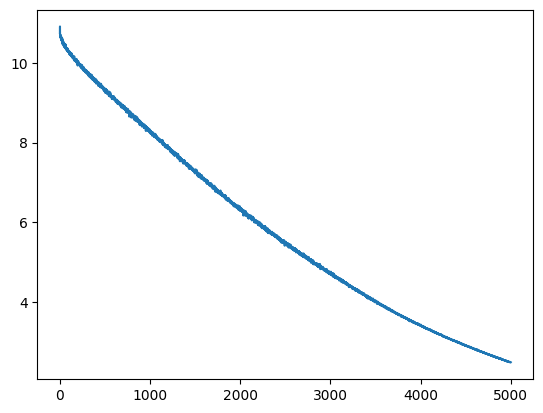

In [7]:
print(f"Position loss: {eval_position(exp.agent, exp.coords, exp.grid_cells):.03f}")
plt.plot(losses)
plt.show()

In [8]:
idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:].numpy() + [[0], [hidden]]
print(net.lin2.weight[2:].detach().cpu().flatten()[idx.flatten()])

tensor([ 0.6902,  0.6922, -0.7003,  0.7054, -0.7179,  0.6261, -0.6275, -0.6547,
         0.6736,  0.6844])


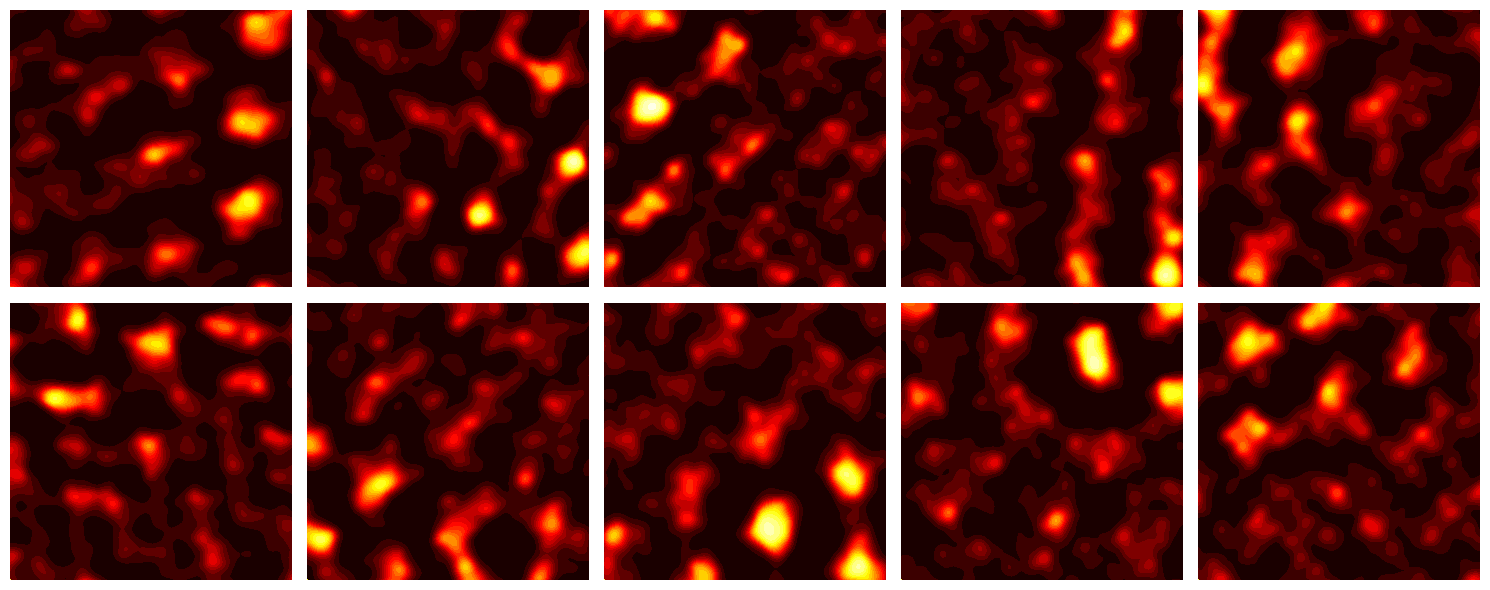

In [9]:
_, axs = plt.subplots(2, 5, figsize=(15, 6))

hidden = net.lin1(exp.grid_cells).permute((-1, 0, 1)).detach().cpu().numpy()
# Small hack to ensure the scale of every plot is the same
hidden[:,0,0] = hidden.max()
hidden[:,0,1] = hidden.min()

idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:]
for img, ax in zip(hidden[idx.flatten()], axs.flatten()):
    ax.contourf(img, levels=20, cmap='hot')
    ax.axis('off')
plt.tight_layout()
plt.show()

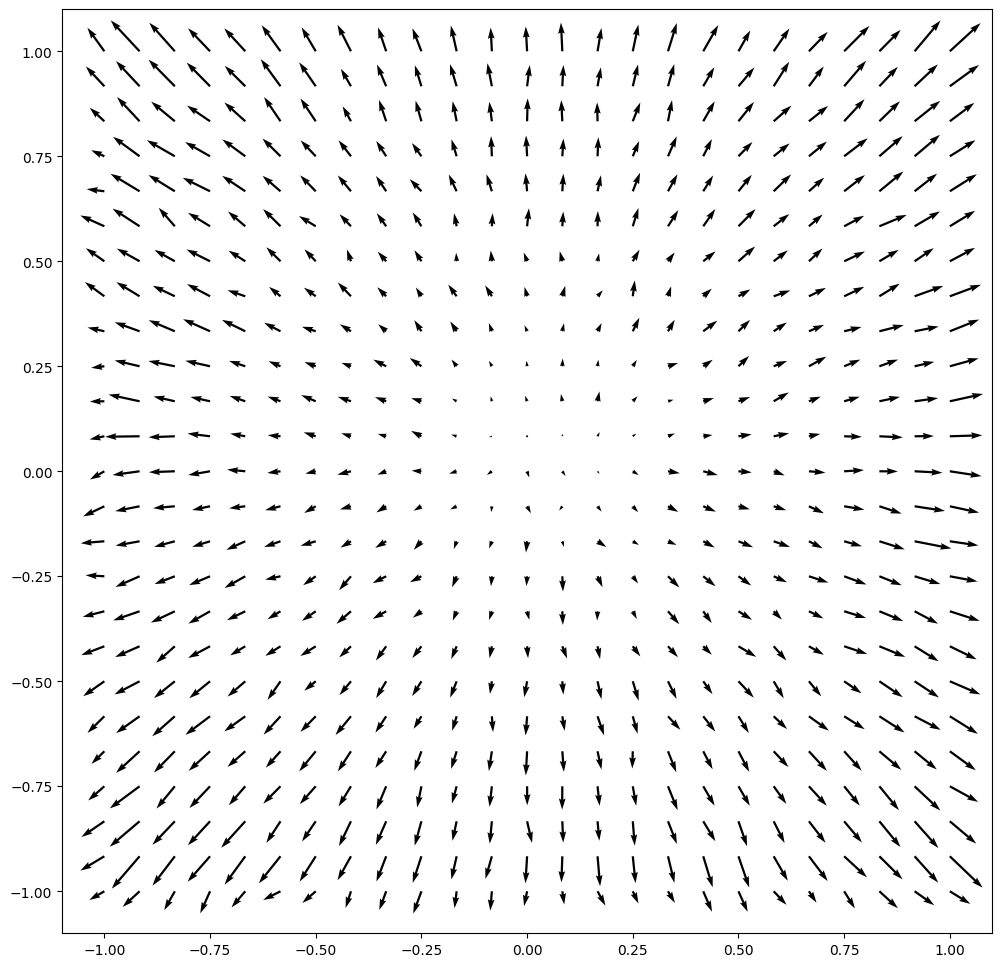

In [10]:
xy = np.linspace(-1, 1, 25)
X, Y = np.meshgrid(xy, xy)

plt.figure(figsize=(12, 12))
plt.quiver(X, Y, *net.lin2(net.lin1(exp.grid_cells))[::16,::16,2:].permute(-1, 0, 1).detach().cpu())
plt.show()

min   |max  |mean |std  |shape
-0.718|0.705|-0.009|0.260|torch.Size([2, 254])
min   |max  |mean |std  |shape
-0.599|0.681|0.016|0.329|torch.Size([2, 246])


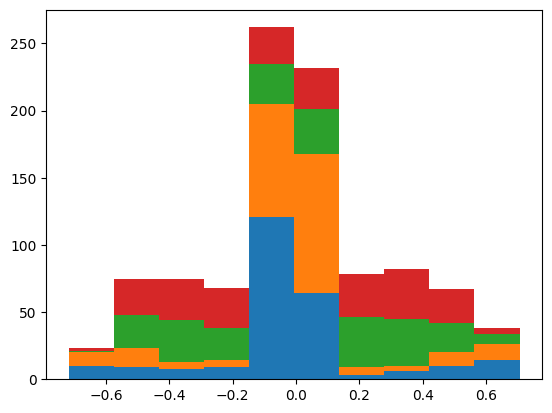

In [11]:
used = hidden.mean((1, 2)) > hidden.mean()# + hidden.mean((1, 2)).std() / 20

print_stats(net.lin2.weight[2:, used])
print_stats(net.lin2.weight[2:, ~used])

plt.hist([*net.lin2.weight[2:, used].detach().cpu(),
          *net.lin2.weight[2:, ~used].detach().cpu()],
         histtype='barstacked')
plt.show()

In [13]:
N = 20
losses = exp.fit_palce_fields(N=N)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:24<00:00, 35.69it/s]


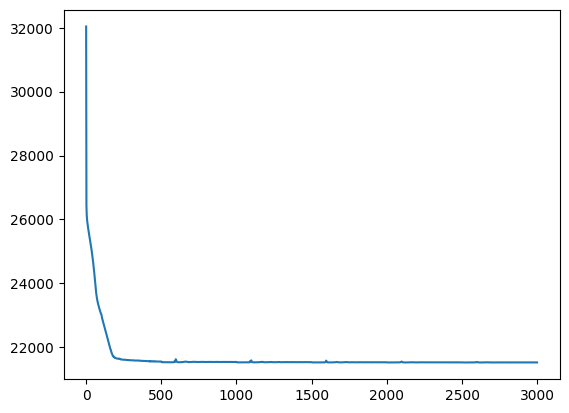

In [14]:
plt.plot(losses[:])

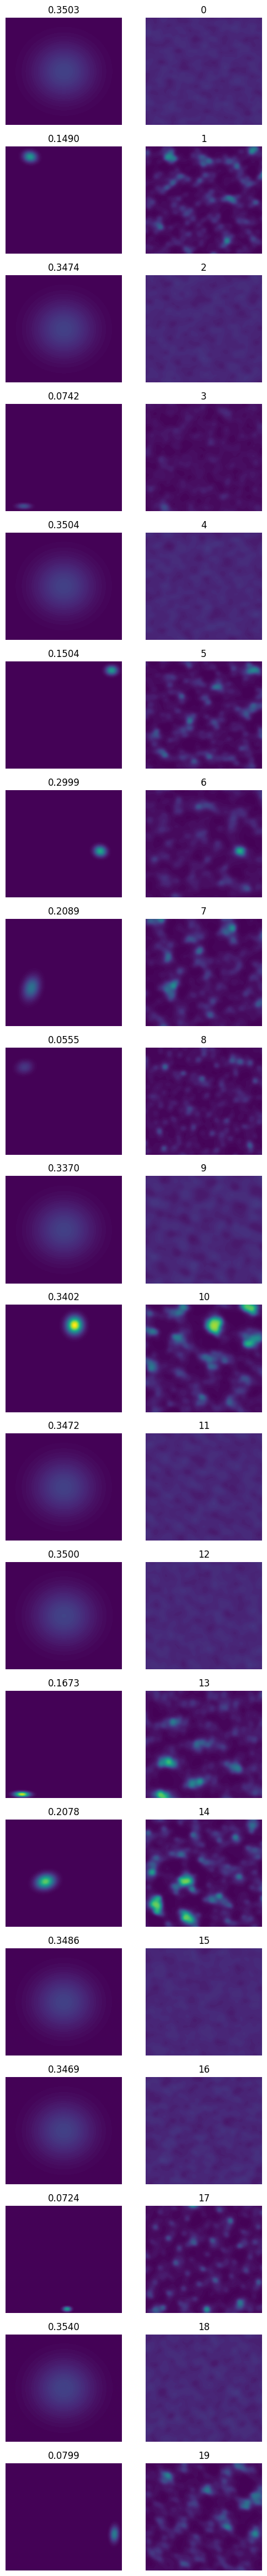

In [19]:
preds = exp.pfs.predict().cpu().detach().numpy()
preds[:,0,0] = hidden.max()
hidden[:,0,0] = hidden.max()
explained = 1 - torch.pow(exp.pfs.predict() - exp.pfs.targets, 2).sum((1, 2)) / torch.pow(exp.pfs.targets, 2).sum((1, 2))

for i, ((ax1, ax2), pred, real, expl) in enumerate(zip(plt.subplots(N, 2, figsize=(6, 3*N))[1],
                                                       preds, hidden[:N], explained.cpu().detach())):
    ax1.contourf(pred, levels=100)
    ax1.axis('off')
    ax1.set_title(f"{expl.item():.04f}")
    ax2.contourf(real, levels=100)
    ax2.axis('off')
    ax2.set_title(i)
plt.show()

In [20]:
exp.save()